In [8]:
!pip install torch==1.5.1+cu92 torchvision==0.6.1+cu92 -f https://download.pytorch.org/whl/torch_stable.html
import torch;print(torch.__version__)

Looking in links: https://download.pytorch.org/whl/torch_stable.html
1.5.1+cu92


In [2]:
import torch
import torch.nn as nn
import numpy as np
import base64
import matplotlib.pyplot as plt
from PIL import Image
import base64
from io import BytesIO

# Generator Code

In [4]:
class Generator(nn.Module):
    """
    Creates the Generator

    nz (int): size of the latent z vector
    ngf (int): number of feature maps for the generator
    """
    def __init__(self, nz: int = 64, ngf: int = 64):
        super(Generator, self).__init__()
        #self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [5]:
nz = 64;ngf = 64;nc = 3

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
netG = Generator(nz, ngf).to(device)

cpu


# LoadModel for deployment

In [6]:
def norm_ip(img, min, max):
    img.clamp_(min=min, max=max)
    img.add_(-min).div_(max - min + 1e-5)

def norm_tensor(t):
    norm_ip(t, float(t.min()), float(t.max()))

In [7]:
netG.load_state_dict(torch.load('/content/drive/My Drive/EVA4/phase2/s6_GAN_carDesign/s6_carGAN_checkpoints/netG_chkpt_1840_torch1.5.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [8]:
netG

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(64, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [9]:
with torch.no_grad():
    fake = netG(torch.randn(1, 64, 1, 1).to(device)).detach().cpu()
fakei = fake[0]
norm_tensor(fakei)

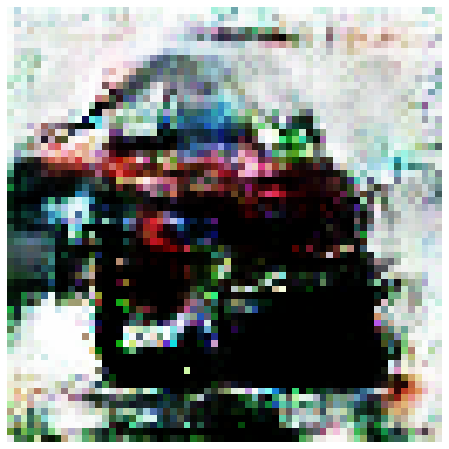

In [10]:
plt.figure(figsize=(8, 8))
plt.imshow(fakei.permute(1, 2, 0))
plt.axis('off')
plt.grid('off')

# Save netG model as a traced one


In [11]:
#torch.save(netG, '/content/drive/My Drive/EVA4/phase2/s6_GAN_carDesign/s6_carGAN_checkpoints/netG_chkpt_1420_1.pth')
traced_model = torch.jit.trace(netG.to('cpu'), torch.randn(1, 64, 1, 1))
traced_model.save('/content/drive/My Drive/EVA4/phase2/s6_GAN_carDesign/s6_carGAN_checkpoints/netG_chkpt_1840_torch1.5_traced.pth')

# Rough to display it in html


#### Convert torch tensor to numpy and display image

(64, 64, 3) <class 'numpy.ndarray'>


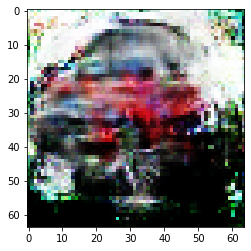

In [6]:
npImg = fakei.permute(1, 2, 0).numpy()

print(npImg.shape,type(npImg))
plt.imshow(npImg)



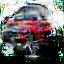

In [7]:
#pil_img = Image.fromarray(npImg.astype("uint8"))
pil_img = Image.fromarray((npImg * 255).astype(np.uint8))
buff = BytesIO()

pil_img.save(buff, format="JPEG")
new_image_string = base64.b64encode(buff.getvalue()).decode("utf-8")
img_str = f"data:image/jpeg;base64,{new_image_string}"
print(img_str)

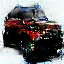

In [ ]:
display(pil_img)

# Load traced model and convert to byte stream

In [5]:
model = torch.jit.load('/content/drive/My Drive/EVA4/phase2/s6_GAN_carDesign/s6_carGAN_checkpoints/netG_chkpt_1840_torch1.5_traced.pth', map_location=torch.device('cpu'))

device = torch.device("cuda:0" if torch.cuda.is_available()  else "cpu")
print(device)
def norm_ip(img, min, max):
    img.clamp_(min=min, max=max)
    img.add_(-min).div_(max - min + 1e-5)

def norm_tensor(t):
    norm_ip(t, float(t.min()), float(t.max()))

with torch.no_grad():
    fake = model(torch.randn(1, 64, 1, 1).to(device)).detach().cpu()
fakei = fake[0]
norm_tensor(fakei)

fakei.shape

cpu


torch.Size([3, 64, 64])